In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

from torchvision import models
import torchvision

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# helper function
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize=(5, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


<h1> Prepare Data</h1>

In [4]:
from datasetv2 import datasetv3

batch_size = 128
resize_size = 299
train_loader, test_loader, train_dataset, test_dataset = datasetv3()

100%|██████████| 4/4 [00:00<00:00, 26.37it/s]


In [5]:
# dataiter = iter(train_loader)
for i, (images, labels) in enumerate(train_loader):
    break
print(type(images))
print(images.shape)
print(labels.shape)
print(type(train_loader))

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<class 'torch.Tensor'>
torch.Size([128, 3, 299, 299])
torch.Size([128])
<class 'torch.utils.data.dataloader.DataLoader'>


In [6]:
model = models.inception_v3(pretrained=True)
model.eval()

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chong\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Use pretrained inception

In [15]:
model = models.inception_v3(pretrained=True)
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False
    
for name, module in model.named_children():
    if isinstance(module, nn.Conv2d):
        # Insert BatchNorm after each Conv2d layer
        setattr(model, name, nn.Sequential(module, nn.BatchNorm2d(module.out_channels)))



# model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 10), nn.Linear(10, 2))
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 4))

model = model.to(device)

# Loss function and optimizer 
loss = nn.CrossEntropyLoss()

# Learning rate and weight decay tuning
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4
)

# print(model.eval())
num_epochs = 15
cap = []
# Early stopping 
# lowestcost = float('inf')
for epoch in range(num_epochs):
    total_batch = len(train_dataset) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.to(device)
        Y = batch_labels.to(device)

        pre = model(X)
        cost = loss(pre, Y)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        # if lowestcost > cost:
        #     lowestcost = cost
        #     torch.save(model, 'saved_model.pt')
            

        if (i + 1) % 5 == 0:
            stdoutput = "Epoch [%d/%d], lter [%d/%d] Loss: %.4f"% (epoch + 1, num_epochs, i + 1, total_batch, cost.item())
            print(stdoutput)

# Save the captured output to a text file
# with open('inceptionv3batchnormv3.txt', 'w') as file:
    # file.write(i for i in stdoutput)


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chong\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialia

Epoch [1/15], lter [5/40] Loss: 1.3620
Epoch [1/15], lter [10/40] Loss: 1.2927
Epoch [1/15], lter [15/40] Loss: 1.2364
Epoch [1/15], lter [20/40] Loss: 1.1792
Epoch [1/15], lter [25/40] Loss: 1.1124
Epoch [1/15], lter [30/40] Loss: 1.1462
Epoch [1/15], lter [35/40] Loss: 1.0994
Epoch [1/15], lter [40/40] Loss: 1.0081
Epoch [2/15], lter [5/40] Loss: 1.0478
Epoch [2/15], lter [10/40] Loss: 1.0835
Epoch [2/15], lter [15/40] Loss: 0.9445
Epoch [2/15], lter [20/40] Loss: 1.0144
Epoch [2/15], lter [25/40] Loss: 0.9272
Epoch [2/15], lter [30/40] Loss: 1.0014
Epoch [2/15], lter [35/40] Loss: 0.9869
Epoch [2/15], lter [40/40] Loss: 0.9928
Epoch [3/15], lter [5/40] Loss: 0.9529
Epoch [3/15], lter [10/40] Loss: 0.8670
Epoch [3/15], lter [15/40] Loss: 0.9438
Epoch [3/15], lter [20/40] Loss: 0.9194
Epoch [3/15], lter [25/40] Loss: 0.9183
Epoch [3/15], lter [30/40] Loss: 0.9642
Epoch [3/15], lter [35/40] Loss: 0.8251
Epoch [3/15], lter [40/40] Loss: 0.8699
Epoch [4/15], lter [5/40] Loss: 0.8918
Epoc

Accuracy of test images: 64.687500 %
Predicted:  Very_Mild_Demented Mild_Demented Non_Demented Moderate_Demented Mild_Demented


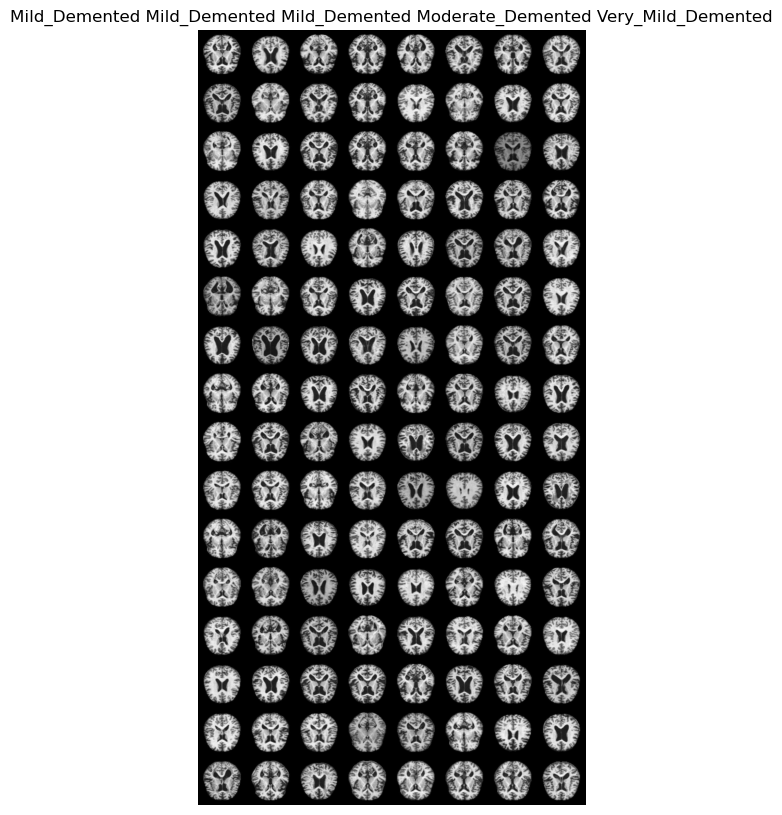

In [16]:
# import ad_labels
# model = torch.load('saved_model.pt')

LABELS_MAP = {
    "Non_Demented": 0,
    "Very_Mild_Demented": 1,
    "Mild_Demented": 2,
    "Moderate_Demented": 3,
}
LABELS_LIST = [
    "Non_Demented",
    "Very_Mild_Demented",
    "Mild_Demented",
    "Moderate_Demented",
]


model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    images = images.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum()

print("Accuracy of test images: %f %%" % (100 * float(correct) / total))

classes = LABELS_LIST

test_iterator = iter(test_loader)
images, labels = next(test_iterator)

outputs = model(images.to(device))

_, predicted = torch.max(outputs.data, 1)

print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(5)))

title = " ".join("%5s" % classes[labels[j]] for j in range(5))
imshow(torchvision.utils.make_grid(images, normalize=True), title)

In [17]:
device

device(type='cuda')

In [18]:
# torch.save(model, 'inceptionv3batchnormv3.pt')

v1: lr 1e-3, epochs 10, batch_siz = 128 58.046875 %
v2: lr 5e-4, epochs 15, batch_siz = 128 57.968750 %
v3: lr 1e-3, epochs 15, batch_siz = 128 58.359375 %
v4: lr 1e-3, epochs 15, batch_siz = 64 58.125000 %
v5: lr 1e-3, epochs 15, batch_siz = 256 60.468750 %
v6: lr 1e-3, epochs 15, batch_siz = 512 56.328125 %

batchnormv1: lr 1e-3, epochs 15, batch_siz = 128 71.875000 %

